# Guide on how to use the backtester

In [2]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

In [3]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

# lets look at peter, he exlcusively trades volcanic rock


In [4]:
th = trades_round_5_all3days.copy()
md = market_data_round_5_all3days.copy()


from tqdm.auto import tqdm
import plotly.graph_objects as go
import pandas as pd
from joblib import Parallel, delayed
import pandas as pd

def plot_price_with_trader_trades_plotly(product: str, trader: str, md: pd.DataFrame, th: pd.DataFrame):
    # Filter market data for the selected product
    market = md[md["product"] == product]

    # Filter trader's trades for the selected product
    trader_trades = th[(th["symbol"] == product) & ((th["buyer"] == trader) | (th["seller"] == trader))]

    # Buys and sells
    trader_buys = trader_trades[trader_trades["buyer"] == trader]
    trader_sells = trader_trades[trader_trades["seller"] == trader]

    # Create figure
    fig = go.Figure()

    # Add mid-price line
    fig.add_trace(go.Scatter(x=market["timestamp"], y=market["mid_price"], mode="lines", name=f"{product} Mid Price", line=dict(color="blue")))

    # Add buy markers
    fig.add_trace(
        go.Scatter(
            x=trader_buys["timestamp"],
            y=trader_buys["price"] - 10,  # offset to make arrow visible
            mode="markers",
            name=f"{trader} Buys",
            marker=dict(symbol="triangle-up", color="green", size=10),
        )
    )

    # Add sell markers
    fig.add_trace(
        go.Scatter(
            x=trader_sells["timestamp"],
            y=trader_sells["price"] + 10,  # offset to make arrow visible
            mode="markers",
            name=f"{trader} Sells",
            marker=dict(symbol="triangle-down", color="red", size=10),
        )
    )

    # Final layout settings
    fig.update_layout(
        title=f"{product} Price Over Time with {trader}'s Trades",
        xaxis_title="Timestamp",
        yaxis_title="Price (SEASHELLS)",
        legend_title="Legend",
        height=600,
        width=1000,
        template="plotly_white",
    )

    fig.show()



def peter_dir_vs_return(md: pd.DataFrame, th: pd.DataFrame, lag: int) -> float:
    product = "VOLCANIC_ROCK"
    trader  = "Peter"

    trades = (
        th[(th["symbol"] == product) &
           ((th["buyer"] == trader) | (th["seller"] == trader))]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )

    market = (
        md[md["product"] == product]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )
    mid    = market["mid_price"].values
    idx_of = {t: i for i, t in enumerate(market["timestamp"].values)}

    dirs = []
    rets = []

    for _, trade in trades.iterrows():
        i = idx_of.get(trade["timestamp"])
        if i is None or i + lag >= len(mid):
            continue
        d = 1 if trade["buyer"] == trader else -1
        r = (mid[i + lag] - mid[i]) / mid[i]
        dirs.append(d)
        rets.append(r)

    if len(dirs) < 2:
        return float("nan")
    return pd.Series(dirs).corr(pd.Series(rets))

# --- load your md, th here ---
# md = ...
# th = ...

# lags = list(range(1, 1000))
# # run in parallel, -1 uses all cores, threading backend to share memory
# results = Parallel(n_jobs=-1,   verbose=5)(
#     delayed(peter_dir_vs_return)(md, th, lag) for lag in lags
# )

# # collect non-nan correlations
# corrs = {lag: corr for lag, corr in zip(lags, results) if not pd.isna(corr)}

# # find the lag with the strongest effect
# best_lag, best_corr = max(corrs.items(), key=lambda kv: abs(kv[1]))
# print(f"Best direction‑only signal at lag={best_lag}: corr={best_corr:.4f}")

In [5]:
s = sorted(corrs.items(), key = lambda x: x[1])

print(s[:10])
print(s[-10:])

NameError: name 'corrs' is not defined

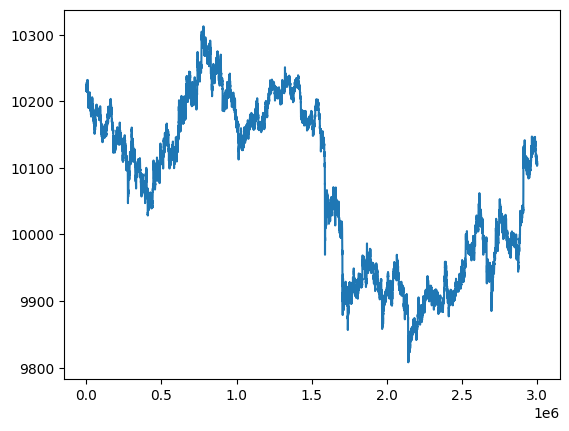

In [ ]:
volc = md[md['product'] == "VOLCANIC_ROCK"]

plt.plot(volc['timestamp'], volc['mid_price'])

In [7]:
plot_price_with_trader_trades_plotly("VOLCANIC_ROCK", "Peter", md, th)

th = th[th['buyer'] == "Peter"]
th

,timestamp,buyer,seller,symbol,currency,price,quantity
130,9300,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10226.0,10
158,10600,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10215.0,10
187,13400,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10200.0,10
573,36000,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10191.0,9
653,42200,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10196.0,8
...,...,...,...,...,...,...,...
16331,2941300,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10093.0,5
16396,2944700,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10099.0,5
16422,2945800,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10090.0,10
16648,2962300,Peter,Caesar,VOLCANIC_ROCK,SEASHELLS,10126.0,5
